# Project 3

### Regression and Classification with the Ames Housing Data

---

You have just joined a new "full stack" real estate company in Ames, Iowa. The strategy of the firm is two-fold:
- Own the entire process from the purchase of the land all the way to sale of the house, and anything in between.
- Use statistical analysis to optimize investment and maximize return.

The company is still small, and though investment is substantial the short-term goals of the company are more oriented towards purchasing existing houses and flipping them as opposed to constructing entirely new houses. That being said, the company has access to a large construction workforce operating at rock-bottom prices.

This project uses the [Ames housing data recently made available on kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

1. Estimating the value of homes from fixed characteristics.
Your superiors have outlined this year's strategy for the company:

Develop an algorithm to reliably estimate the value of residential houses based on fixed characteristics.
Identify characteristics of houses that the company can cost-effectively change/renovate with their construction team.
Evaluate the mean dollar value of different renovations.
Then we can use that to buy houses that are likely to sell for more than the cost of the purchase plus renovations.

Your first job is to tackle #1. You have a dataset of housing sale data with a huge amount of features identifying different aspects of the house. The full description of the data features can be found in a separate file:

housing.csv
data_description.txt
You need to build a reliable estimator for the price of the house given characteristics of the house that cannot be renovated. Some examples include:

The neighborhood
Square feet
Bedrooms, bathrooms
Basement and garage space
and many more.

Some examples of things that ARE renovate-able:

Roof and exterior features
"Quality" metrics, such as kitchen quality
"Condition" metrics, such as condition of garage
Heating and electrical components
and generally anything you deem can be modified without having to undergo major construction on the house.

Your goals:

1. Perform any cleaning, feature engineering, and EDA you deem necessary.
2. Be sure to remove any houses that are not residential from the dataset.
3. Identify fixed features that can predict price.
4. Train a model on pre-2010 data and evaluate its performance on the 2010 houses.
5. Characterize your model. How well does it perform? What are the best estimates of price?


In [1]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [2]:
# Load data
house = pd.read_csv('./housing.csv')

# Convert column names to lowercase
house.columns=[x.lower() for x in house.columns]


In [3]:
'''
MSZoning: Identifies the general zoning classification of the sale.
		
       A	Agriculture
       C	Commercial
       FV	Floating Village Residential
       I	Industrial
       RH	Residential High Density
       RL	Residential Low Density
       RP	Residential Low Density Park 
       RM	Residential Medium Density
	
'''
# filter only residential from mszoning
commercial_zoning = ['A','C (all)','I']
house = house[~house['mszoning'].isin(commercial_zoning)]
house['mszoning'].value_counts() #check to ensure only residential remain

RL    1151
RM     218
FV      65
RH      16
Name: mszoning, dtype: int64

## Check for missing data and fill in

In [4]:
house.loc[:,pd.isnull(house).any()].head(5)

,lotfrontage,alley,masvnrtype,masvnrarea,bsmtqual,bsmtcond,bsmtexposure,bsmtfintype1,bsmtfintype2,electrical,fireplacequ,garagetype,garageyrblt,garagefinish,garagequal,garagecond,poolqc,fence,miscfeature
0,65.0,NaN,BrkFace,196.0,Gd,TA,No,GLQ,Unf,SBrkr,NaN,Attchd,2003.0,RFn,TA,TA,NaN,NaN,NaN
1,80.0,NaN,None,0.0,Gd,TA,Gd,ALQ,Unf,SBrkr,TA,Attchd,1976.0,RFn,TA,TA,NaN,NaN,NaN
2,68.0,NaN,BrkFace,162.0,Gd,TA,Mn,GLQ,Unf,SBrkr,TA,Attchd,2001.0,RFn,TA,TA,NaN,NaN,NaN
3,60.0,NaN,None,0.0,TA,Gd,No,ALQ,Unf,SBrkr,Gd,Detchd,1998.0,Unf,TA,TA,NaN,NaN,NaN
4,84.0,NaN,BrkFace,350.0,Gd,TA,Av,GLQ,Unf,SBrkr,TA,Attchd,2000.0,RFn,TA,TA,NaN,NaN,NaN


In [5]:
# fillna LotFrontage: Linear feet of street connected to property
print house['lotfrontage'].describe()

# Decision: fillna with mean 
house['lotfrontage'] = house['lotfrontage'].fillna(house['lotfrontage'].mean())



count    1191.000000
mean       70.052897
std        24.301013
min        21.000000
25%        59.000000
50%        70.000000
75%        80.000000
max       313.000000
Name: lotfrontage, dtype: float64


In [6]:
# fillna 'alley'
print house['alley'].value_counts()
# since there are only 89 filled rows vs total 1450, drop alley
 
house = house.drop(['alley'],axis =1)

Grvl    50
Pave    39
Name: alley, dtype: int64


In [7]:
#likewise 'masvnrtype' MasVnrType: Masonry veneer type
house = house.drop(['masvnrtype'],axis =1)

count    1442.000000
mean      104.404300
std       181.486539
min         0.000000
25%         0.000000
50%         0.000000
75%       166.750000
max      1600.000000
Name: masvnrarea, dtype: float64


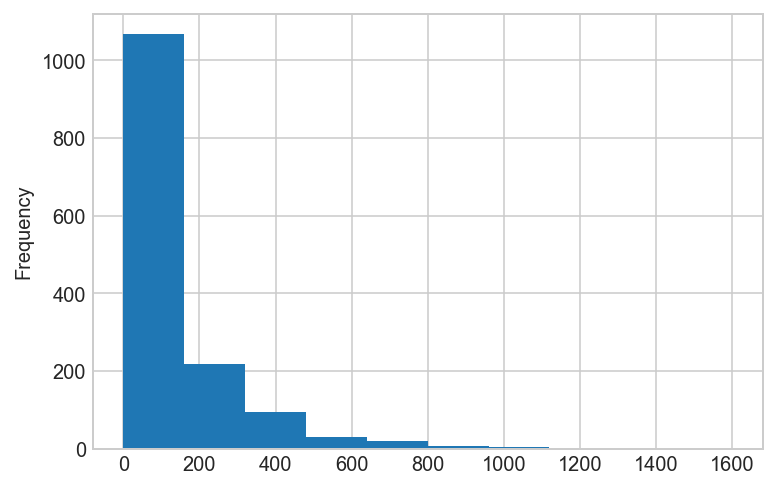

In [8]:
# Treatment of masvnrarea: Masonry veneer area in square feet
print house['masvnrarea'].describe()
house['masvnrarea'].plot(kind='hist') # unusual stats
plt.show()

In [9]:
# decision to drop as fillna may not be meaningful
house = house.drop(['masvnrarea'],axis =1)

In [10]:
'''
bsmtqual evaluates basement height (Ex, Gd, TA, Fa, Po, NA)
NA means no basement, not null value
replace NA with No
'''
house['bsmtqual'] = house['bsmtqual'].fillna('No')
house['bsmtcond'] = house['bsmtcond'].fillna('No')
house['bsmtexposure'] = house['bsmtexposure'].fillna('No')
house['bsmtfintype1'] = house['bsmtfintype1'].fillna('No')
house['bsmtfintype2'] = house['bsmtfintype2'].fillna('No')
house['fireplacequ'] = house['fireplacequ'].fillna('No')

#garagetype fillna with No, and drop garageyrblt as this field is assumed to be the same as age of house or yrbuilt
house['garagetype'] = house['garagetype'].fillna('No')
house = house.drop(['garageyrblt'],axis =1)
house['garagefinish'] = house['garagefinish'].fillna('No')
house['garagequal'] = house['garagequal'].fillna('No')
house['garagecond'] = house['garagecond'].fillna('No')

house['poolqc'] = house['poolqc'].fillna('No')

house['fence'] = house['fence'].fillna('No')
house['miscfeature'] = house['miscfeature'].fillna('No')
pd.crosstab(house.housestyle,house.bsmtqual)

bsmtqual,Ex,Fa,Gd,No,TA
housestyle,,,,,
1.5Fin,1,8,19,5,117
1.5Unf,0,1,0,0,13
1Story,76,15,273,27,331
2.5Fin,1,0,0,0,7
2.5Unf,0,0,2,0,8
2Story,42,11,267,4,120
SFoyer,0,0,28,1,8
SLvl,1,0,29,0,35


In [11]:
# electrical 

print house['electrical'].value_counts()
house['electrical'] = house['electrical'].fillna('SBrkr') # SBrkr is the most common type

SBrkr    1328
FuseA      90
FuseF      27
FuseP       3
Mix         1
Name: electrical, dtype: int64


In [12]:
# add an age column and remod_time, assuming current year is 2018

house['age'] = 2018 - house['yearbuilt']
house['remod_age']=2018-house['yearremodadd']

In [13]:
# final check for duplicate rows
house.duplicated().sum()

0

In [14]:
house.to_csv('h2.csv')